In [8]:
from __future__ import division
from scipy import misc
import numpy as np
import matplotlib.pyplot as plt
%autoreload 2

We want to implement Chambolle dual algorithm for a denoising problem with a additional l1 reg. term.

/var/folders/82/ct149nrx5hdgcw9rz3p2plzh0000gp/T/ipykernel_18577/1832818123.py:2: DeprecationWarning: scipy.misc.ascent has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.ascent instead.
  xsharp = misc.ascent()


AttributeError: module 'numpy' has no attribute 'randn'

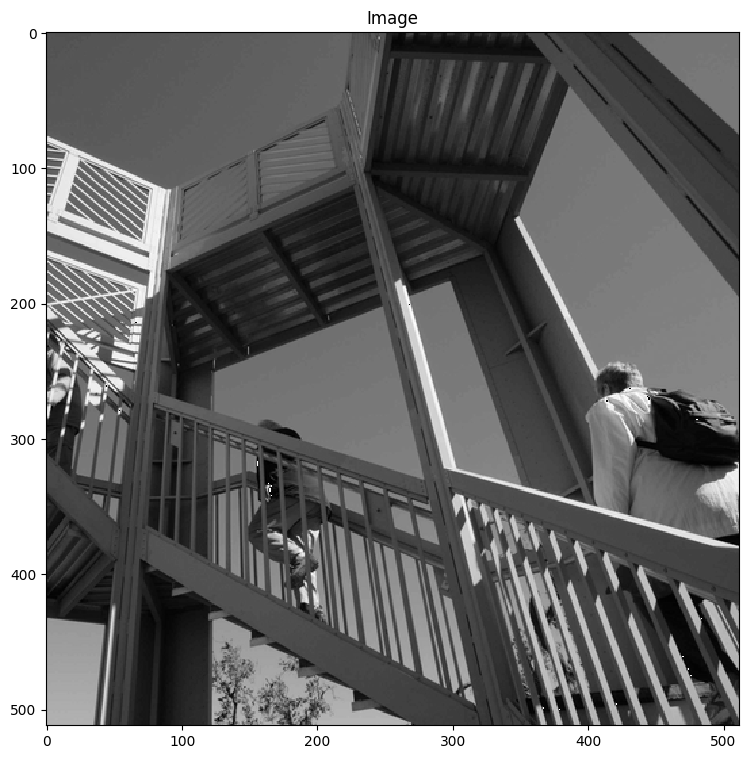

In [31]:
'''Generating input :'''
xsharp = misc.ascent()
xsharp = xsharp.astype(np.float32) #create image
figsize(9,9)
imshow(xsharp, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
title('Image')
'''Add Noise'''
(N1,N2) = np.shape(xsharp)
noiselevel = 20
noised_image = xsharp + noiselevel * np.randn(N1,N2)




In [60]:
# '''Chambolle algo'''
# Lambda = 25
# gamma = 1.9/8 # we must have 0 < gamma < 2/8
# nbiter = 400
# (N1,N2) = y.shape
# u = np.zeros([N1,N2,2])
# Ep_array = np.zeros(nbiter) # array for the primal energy E_p
# Ed_array = np.zeros(nbiter) # array for the dual energy E_d
# sqnormy = np.norm(y)**2/2
# for iter in range(nbiter):  
#     # put your code here
#     x=x - Dadj((u))+y
#     u = prox_g_conj(u+gamma*D(x),Lambda)
#     Ep_array[iter] = norm(x-y)**2/2 + Lambda*sum(sqrt(sum(D(x)**2,2))) 
#     Ed_array[iter] = norm(y-Dadj(u))**2/2 - sqnormy
# xdenoised = x


Dadj = lambda v : np.r_['0,2',-v[0,:,0],-np.diff(v[:-1,:,0],1,0),v[-2,:,0]] + np.c_['1,2',-v[:,0,1],-np.diff(v[:,:-1,1],1,1),v[:,-2,1]]
D = lambda x : np.c_['2,3',np.r_[np.diff(x,1,0), np.zeros([1,x.shape[1]])],np.c_[np.diff(x,1,1), np.zeros([x.shape[0],1])]]


def prox_g_conj(u, Lambda): 
    return u/np.tile(np.maximum(np.sqrt(sum(u**2,2,keepdims=True))/Lambda,1),(1,1,2)) # soft-thresholding

def proximal_operator_lasso(u, Lambda):
    gamma = 1
    return u - Lambda * np.sign(u) * np.maximum(0, np.abs(prox_g_conj(u, Lambda))-0.1)

def Ep_simple(x, y, Lambda, alpha):
    return  np.linalg.norm(x-y)**2/2 + Lambda*sum(np.sqrt(sum(D(x)**2,2))) 

def Ed_simple(u, y, Lambda, alpha):
    sqnormy = np.linalg.norm(y)**2/2
    return  np.linalg.norm(y-Dadj(u))**2/2 - sqnormy

def Ep_with_lasso_term(x, y, Lambda, alpha):
    # Compute differences along the x (horizontal) axis
    dx = np.diff(x, axis=1)
    # Compute differences along the y (vertical) axis
    dy = np.diff(x, axis=0)
    # Compute the total variation norm
    tv_norm = Lambda*sum(np.sqrt(np.sum(D(x)**2,2))) 
    return np.linalg.norm(x-y)**2/2 + Lambda * tv_norm + alpha * np.linalg.norm(x, ord=1)

def Ed_with_lasso_term(x, y, Lambda, alpha):
    return np.linalg.norm(y-Dadj(x))**2/2



def chambolle(input_image, _Ep, _Ed, proximal_operator, Lambda = 25, gamma = 1.9/8, nbIter = 400, alpha = 1):
    (N1,N2) = input_image.shape
    u = np.zeros([N1,N2,2])
    Ep_array = np.zeros(nbIter) # array for the primal energy E_p
    Ed_array = np.zeros(nbIter) # array for the dual energy E_d
    for iter in range(nbIter):  
        # Forward step: gradient descent on g
        x=- Dadj((u))+input_image

        # Backward step: proximal operator on h
        u = proximal_operator(u+gamma*D(x), Lambda)
        # put your code here
        Ep_array[iter] = _Ep(x, input_image, Lambda, alpha)
        #Ed_array[iter] = _Ed(u, input_image)
    xdenoised = x
    return xdenoised

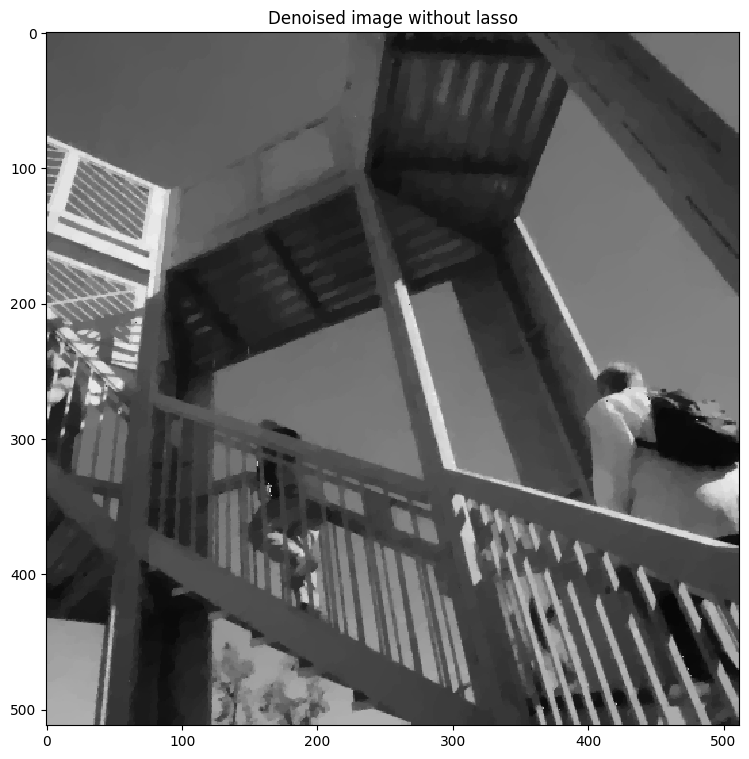

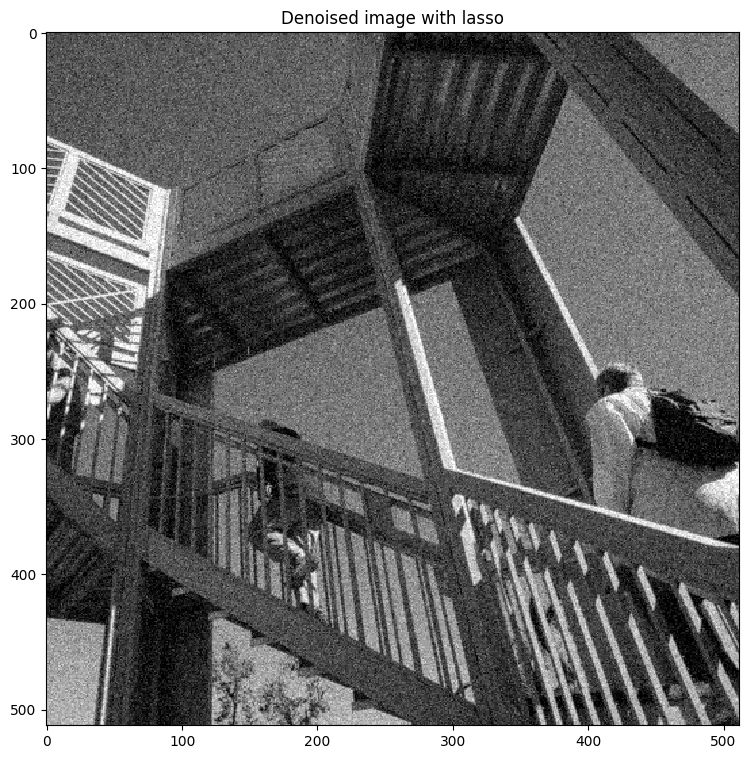

In [61]:
xDenoinsed_1 = chambolle(noised_image, Ep_simple, Ed_simple, prox_g_conj)
xDenoinsed_2 = chambolle(noised_image, Ep_with_lasso_term, Ed_with_lasso_term, proximal_operator_lasso)

figsize(9,9)
imshow(xDenoinsed_1, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
title('Denoised image without lasso')
show()
figsize(9,9)
imshow(xDenoinsed_2, interpolation='nearest', cmap=cm.gray, vmin=0, vmax=255)
title('Denoised image with lasso')
show()


In [ ]:
# Create a figure with a row of 3 subplots
fig, axs = plt.subplots(1, 4, figsize=(15, 5))


axs[0].imshow(xsharp, cmap='gray')
axs[0].set_title('Image with nois')

# Display each image in a subplot
axs[1].imshow(noised_image, cmap='gray')
axs[1].set_title('Image with nois')

axs[2].imshow(xDenoinsed_1, cmap='gray')
axs[2].set_title('Image denoised without lasso')

axs[3].imshow(xDenoinsed_2, cmap='gray')
axs[3].set_title('Image denoised with lasso')

# Remove axes for a cleaner look
for ax in axs:
    ax.axis('off')

# Show the plot
plt.tight_layout()
plt.show()